# Baseline Model: HOG Features + Linear Classifier

This notebook implements a second baseline using **Histogram of Oriented Gradients (HOG)** features with linear classifiers.

## Why HOG?

HOG captures **shape and texture** information by:
- Computing gradient orientations in local image regions
- Creating histograms of these orientations
- Encoding edge patterns and textures (e.g., spotting, bruising, skin texture)

Unlike kNN (raw pixels), HOG provides **hand-crafted features** that are more robust to lighting variations and capture local structure.

## Models to Compare:
1. **Logistic Regression** (multinomial) - Fast, interpretable
2. **Linear SVM** - Maximum margin classifier
3. **Both will use HOG features** extracted from fruit images

## Dataset:
- 9 classes: {fresh, rotten, unripe} × {apples, banana, oranges}
- Train/test split from `datasetcopy/`

## Comparison:
- **kNN baseline**: 74.4% (raw pixels, K=1)
- **HOG + Linear**: Expected ~60-75% (shape/texture features)
- **CNN**: 84.5% (learned hierarchical features)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import Counter
import pickle

# HOG feature extraction
from skimage.feature import hog
from skimage import exposure

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 1. Configuration & Dataset Loading

In [2]:
# Configuration
DATA_ROOT = Path("../datasetcopy")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"
IMAGE_SIZE = 128  # Larger than kNN (64x64) to capture more detail for HOG

# HOG parameters (these are standard values that work well)
HOG_ORIENTATIONS = 9  # Number of orientation bins
HOG_PIXELS_PER_CELL = (8, 8)  # Size of cells
HOG_CELLS_PER_BLOCK = (2, 2)  # Number of cells per block for normalization

# Class names
CLASS_NAMES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
print(f"Classes ({len(CLASS_NAMES)}): {CLASS_NAMES}")
print(f"\nHOG Configuration:")
print(f"  - Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"  - Orientations: {HOG_ORIENTATIONS}")
print(f"  - Pixels per cell: {HOG_PIXELS_PER_CELL}")
print(f"  - Cells per block: {HOG_CELLS_PER_BLOCK}")

Classes (9): ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'unripe apple', 'unripe banana', 'unripe orange']

HOG Configuration:
  - Image size: 128×128
  - Orientations: 9
  - Pixels per cell: (8, 8)
  - Cells per block: (2, 2)


## 2. Load Images and Extract HOG Features

We'll load images and immediately extract HOG features. This is more memory-efficient than storing all images.

In [3]:
def extract_hog_features(image, image_size=128, orientations=9, 
                         pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Extract HOG features from an image.
    
    Args:
        image: PIL Image or numpy array
        image_size: Target size for resizing
        orientations: Number of orientation bins
        pixels_per_cell: Size of cells
        cells_per_block: Number of cells per block
    
    Returns:
        HOG feature vector (1D numpy array)
    """
    # Convert to grayscale (HOG works on grayscale images)
    if isinstance(image, Image.Image):
        image = image.convert('L')  # Convert PIL image to grayscale
        image = image.resize((image_size, image_size), Image.Resampling.BILINEAR)
        image = np.array(image)
    else:
        # If numpy array, convert to grayscale if needed
        if len(image.shape) == 3:
            # RGB to grayscale: 0.299*R + 0.587*G + 0.114*B
            image = np.dot(image[...,:3], [0.299, 0.587, 0.114])
    
    # Extract HOG features
    features = hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',  # Normalization method
        visualize=False,
        feature_vector=True
    )
    
    return features


def load_images_and_extract_hog(folder, class_names, image_size=128, 
                                 orientations=9, pixels_per_cell=(8, 8), 
                                 cells_per_block=(2, 2)):
    """
    Load images from a folder and extract HOG features.
    
    Returns:
        X: numpy array of HOG features (num_images, feature_dim)
        y: numpy array of labels (num_images,)
        class_names: list of class names
    """
    features_list = []
    labels_list = []
    
    for class_idx, class_name in enumerate(class_names):
        class_folder = folder / class_name
        if not class_folder.exists():
            print(f"Warning: {class_folder} does not exist, skipping...")
            continue
        
        image_files = list(class_folder.glob("*.png")) + list(class_folder.glob("*.jpg"))
        print(f"Loading {len(image_files)} images from {class_name}...")
        
        for img_path in tqdm(image_files, desc=f"Extracting HOG for {class_name}"):
            try:
                # Load image
                img = Image.open(img_path)
                
                # Extract HOG features
                hog_features = extract_hog_features(
                    img, image_size, orientations, 
                    pixels_per_cell, cells_per_block
                )
                
                features_list.append(hog_features)
                labels_list.append(class_idx)
                
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    X = np.array(features_list)
    y = np.array(labels_list)
    
    return X, y, class_names

In [4]:
# Load training data and extract HOG features
print("\n=== Loading Training Data & Extracting HOG Features ===")
X_train_hog, y_train, class_names = load_images_and_extract_hog(
    TRAIN_DIR, CLASS_NAMES, IMAGE_SIZE, 
    HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK
)

print(f"\nTraining set:")
print(f"  - Samples: {X_train_hog.shape[0]}")
print(f"  - HOG feature dimensions: {X_train_hog.shape[1]}")
print(f"  - Labels shape: {y_train.shape}")


=== Loading Training Data & Extracting HOG Features ===
Loading 1693 images from freshapples...


Extracting HOG for freshapples: 100%|██████████| 1693/1693 [00:10<00:00, 164.53it/s]


Loading 1581 images from freshbanana...


Extracting HOG for freshbanana: 100%|██████████| 1581/1581 [00:10<00:00, 157.38it/s]


Loading 1466 images from freshoranges...


Extracting HOG for freshoranges: 100%|██████████| 1466/1466 [00:08<00:00, 168.38it/s]


Loading 2342 images from rottenapples...


Extracting HOG for rottenapples: 100%|██████████| 2342/2342 [00:14<00:00, 166.79it/s]


Loading 2224 images from rottenbanana...


Extracting HOG for rottenbanana: 100%|██████████| 2224/2224 [00:14<00:00, 153.21it/s]


Loading 1595 images from rottenoranges...


Extracting HOG for rottenoranges: 100%|██████████| 1595/1595 [00:10<00:00, 157.20it/s]


Loading 1934 images from unripe apple...


Extracting HOG for unripe apple: 100%|██████████| 1934/1934 [00:06<00:00, 284.24it/s]


Loading 2097 images from unripe banana...


Extracting HOG for unripe banana: 100%|██████████| 2097/2097 [00:07<00:00, 287.02it/s]


Loading 1285 images from unripe orange...


Extracting HOG for unripe orange: 100%|██████████| 1285/1285 [00:04<00:00, 282.42it/s]



Training set:
  - Samples: 16217
  - HOG feature dimensions: 8100
  - Labels shape: (16217,)


In [5]:
# Load test data and extract HOG features
print("\n=== Loading Test Data & Extracting HOG Features ===")
X_test_hog, y_test, _ = load_images_and_extract_hog(
    TEST_DIR, CLASS_NAMES, IMAGE_SIZE,
    HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK
)

print(f"\nTest set:")
print(f"  - Samples: {X_test_hog.shape[0]}")
print(f"  - HOG feature dimensions: {X_test_hog.shape[1]}")
print(f"  - Labels shape: {y_test.shape}")


=== Loading Test Data & Extracting HOG Features ===
Loading 395 images from freshapples...


Extracting HOG for freshapples: 100%|██████████| 395/395 [00:02<00:00, 156.53it/s]


Loading 381 images from freshbanana...


Extracting HOG for freshbanana: 100%|██████████| 381/381 [00:02<00:00, 150.42it/s]


Loading 388 images from freshoranges...


Extracting HOG for freshoranges: 100%|██████████| 388/388 [00:02<00:00, 160.79it/s]


Loading 601 images from rottenapples...


Extracting HOG for rottenapples: 100%|██████████| 601/601 [00:03<00:00, 165.88it/s]


Loading 530 images from rottenbanana...


Extracting HOG for rottenbanana: 100%|██████████| 530/530 [00:03<00:00, 150.01it/s]


Loading 403 images from rottenoranges...


Extracting HOG for rottenoranges: 100%|██████████| 403/403 [00:02<00:00, 155.68it/s]


Loading 371 images from unripe apple...


Extracting HOG for unripe apple: 100%|██████████| 371/371 [00:01<00:00, 280.24it/s]


Loading 400 images from unripe banana...


Extracting HOG for unripe banana: 100%|██████████| 400/400 [00:01<00:00, 287.50it/s]


Loading 270 images from unripe orange...


Extracting HOG for unripe orange: 100%|██████████| 270/270 [00:01<00:00, 253.03it/s]


Test set:
  - Samples: 3739
  - HOG feature dimensions: 8100
  - Labels shape: (3739,)


In [6]:
# Check class distribution
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("\n=== Class Distribution ===")
print("\nTraining set:")
for idx, name in enumerate(class_names):
    count = train_counts.get(idx, 0)
    pct = 100 * count / len(y_train)
    print(f"  {name:20s}: {count:4d} ({pct:5.1f}%)")

print("\nTest set:")
for idx, name in enumerate(class_names):
    count = test_counts.get(idx, 0)
    pct = 100 * count / len(y_test)
    print(f"  {name:20s}: {count:4d} ({pct:5.1f}%)")


=== Class Distribution ===

Training set:
  freshapples         : 1693 ( 10.4%)
  freshbanana         : 1581 (  9.7%)
  freshoranges        : 1466 (  9.0%)
  rottenapples        : 2342 ( 14.4%)
  rottenbanana        : 2224 ( 13.7%)
  rottenoranges       : 1595 (  9.8%)
  unripe apple        : 1934 ( 11.9%)
  unripe banana       : 2097 ( 12.9%)
  unripe orange       : 1285 (  7.9%)

Test set:
  freshapples         :  395 ( 10.6%)
  freshbanana         :  381 ( 10.2%)
  freshoranges        :  388 ( 10.4%)
  rottenapples        :  601 ( 16.1%)
  rottenbanana        :  530 ( 14.2%)
  rottenoranges       :  403 ( 10.8%)
  unripe apple        :  371 (  9.9%)
  unripe banana       :  400 ( 10.7%)
  unripe orange       :  270 (  7.2%)


## 3. Visualize HOG Features (Optional)

Let's visualize what HOG features look like for a few sample images.

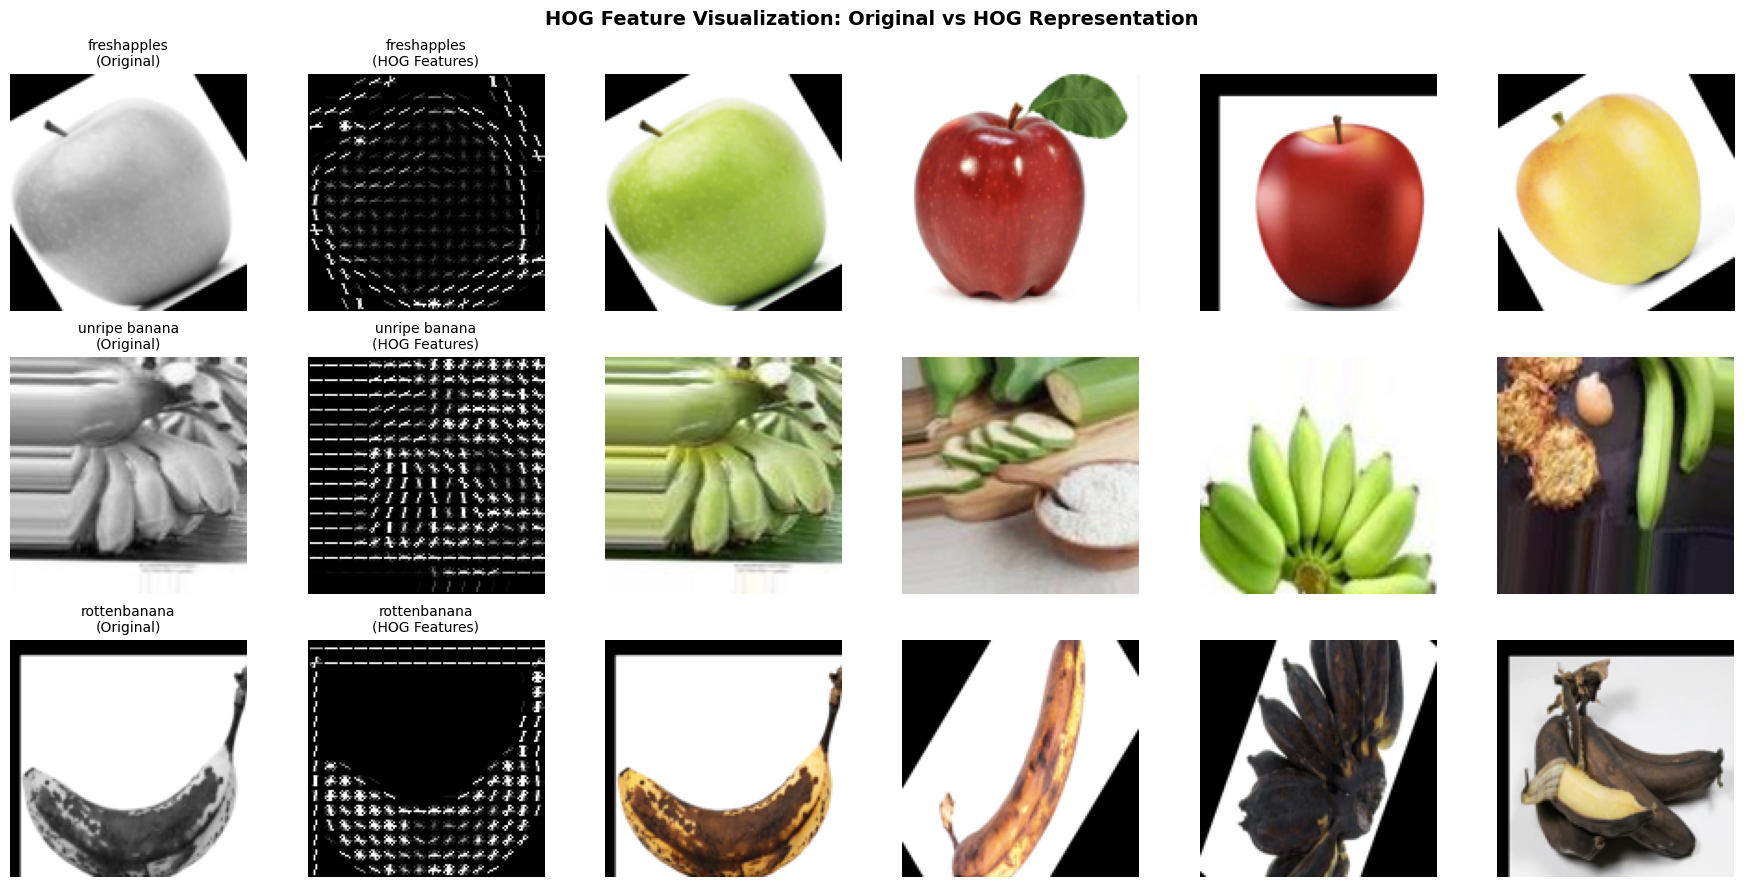

HOG captures edge orientations and gradients, which encode shape and texture.
Notice how rotten fruits show different edge patterns (spotting, discoloration).


In [7]:
def visualize_hog(image_path, image_size=128, orientations=9, 
                  pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """Visualize an image and its HOG representation."""
    # Load and preprocess image
    img = Image.open(image_path).convert('L')
    img = img.resize((image_size, image_size), Image.Resampling.BILINEAR)
    img_array = np.array(img)
    
    # Extract HOG with visualization
    hog_features, hog_image = hog(
        img_array,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )
    
    # Rescale HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    return img_array, hog_image_rescaled

# Visualize HOG for sample images from each class
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

sample_classes = ['freshapples', 'unripe banana', 'rottenbanana']  # 3 diverse classes
for row_idx, class_name in enumerate(sample_classes):
    class_folder = TRAIN_DIR / class_name
    image_files = list(class_folder.glob("*.png")) + list(class_folder.glob("*.jpg"))
    
    if len(image_files) > 0:
        # Get first image
        sample_img = image_files[0]
        img_array, hog_vis = visualize_hog(sample_img, IMAGE_SIZE, HOG_ORIENTATIONS,
                                           HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK)
        
        # Original image (grayscale)
        axes[row_idx, 0].imshow(img_array, cmap='gray')
        axes[row_idx, 0].set_title(f'{class_name}\n(Original)', fontsize=10)
        axes[row_idx, 0].axis('off')
        
        # HOG visualization
        axes[row_idx, 1].imshow(hog_vis, cmap='gray')
        axes[row_idx, 1].set_title(f'{class_name}\n(HOG Features)', fontsize=10)
        axes[row_idx, 1].axis('off')
        
        # Show 4 more examples
        for col_idx in range(2, 6):
            if col_idx - 2 < len(image_files):
                sample_img = image_files[col_idx - 2]
                img_color = Image.open(sample_img).resize((IMAGE_SIZE, IMAGE_SIZE))
                axes[row_idx, col_idx].imshow(img_color)
                axes[row_idx, col_idx].axis('off')

plt.suptitle('HOG Feature Visualization: Original vs HOG Representation', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('artefacts/hog_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("HOG captures edge orientations and gradients, which encode shape and texture.")
print("Notice how rotten fruits show different edge patterns (spotting, discoloration).")

## 4. Normalize Features

Linear classifiers benefit from feature normalization (zero mean, unit variance).

In [8]:
# Standardize features (important for linear classifiers)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)

print("Feature normalization complete")
print(f"Train features - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Test features - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

Feature normalization complete
Train features - Mean: -0.000000, Std: 1.000000
Test features - Mean: 0.013081, Std: 0.980280


## 5. Baseline 1: Logistic Regression

Multinomial logistic regression with L2 regularization.

In [9]:
print("\n=== Training Logistic Regression ===")
print("Using multinomial logistic regression with L2 regularization...")

# Train logistic regression
lr_classifier = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',  # Good for multiclass
    max_iter=1000,
    C=1.0,  # Inverse regularization strength (smaller = more regularization)
    random_state=42,
    n_jobs=-1
)

lr_classifier.fit(X_train_scaled, y_train)
print("Training complete!")

# Predict on test set
y_pred_lr = lr_classifier.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"\n{'='*70}")
print(f"LOGISTIC REGRESSION ACCURACY: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"{'='*70}")


=== Training Logistic Regression ===
Using multinomial logistic regression with L2 regularization...


/Users/catalinathomson/Library/CloudStorage/OneDrive-UniversityofCapeTown/AI/Assignment 2/CSC4025Z_Ass2_Fruit_Ripeness/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training complete!

LOGISTIC REGRESSION ACCURACY: 0.5927 (59.27%)


## 6. Baseline 2: Linear SVM

Linear Support Vector Machine with L2 regularization.

In [ ]:
print("\n=== Training Linear SVM ===")
print("Using LinearSVC with L2 regularization...")

# Train linear SVM
svm_classifier = LinearSVC(
    C=1.0,  # Regularization parameter
    max_iter=2000,
    random_state=42,
    dual=False  # Preferred when n_samples > n_features
)

svm_classifier.fit(X_train_scaled, y_train)
print("Training complete!")

# Predict on test set
y_pred_svm = svm_classifier.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

print(f"\n{'='*70}")
print(f"LINEAR SVM ACCURACY: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"{'='*70}")


=== Training Linear SVM ===
Using LinearSVC with L2 regularization...


## 7. Detailed Results & Comparison

In [ ]:
# Choose best model for detailed analysis
if lr_accuracy > svm_accuracy:
    best_model_name = "Logistic Regression"
    y_pred_best = y_pred_lr
    best_accuracy = lr_accuracy
else:
    best_model_name = "Linear SVM"
    y_pred_best = y_pred_svm
    best_accuracy = svm_accuracy

print(f"\n=== Classification Report: {best_model_name} ===")
print(classification_report(y_test, y_pred_best, target_names=class_names, digits=4))

In [ ]:
# Confusion matrices for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_title(f'Logistic Regression\nAccuracy: {lr_accuracy:.4f}', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Linear SVM confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_title(f'Linear SVM\nAccuracy: {svm_accuracy:.4f}', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('HOG + Linear Classifier: Confusion Matrices', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('artefacts/hog_linear_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Comprehensive comparison table
print("\n" + "="*80)
print("COMPREHENSIVE BASELINE COMPARISON")
print("="*80)
print(f"{'Model':<40s} {'Test Accuracy':<15s} {'Features/Method'}")
print("-"*80)
print(f"{'Random (uniform)':<40s} {0.111:<15.4f} {'1/9 classes'}")
print(f"{'Majority Class':<40s} {'~0.11-0.15':<15s} {'Always predict most common'}")
print(f"{'kNN (K=1, raw pixels)':<40s} {0.744:<15.4f} {'Euclidean distance, 64×64'}")
print(f"{'Logistic Regression (HOG features)':<40s} {lr_accuracy:<15.4f} {'HOG + L2 regularization'}")
print(f"{'Linear SVM (HOG features)':<40s} {svm_accuracy:<15.4f} {'HOG + max margin'}")
print(f"{'CNN (baseline_cnn_pytorch)':<40s} {0.845:<15.4f} {'Learned features, 20 epochs'}")
print("="*80)

# Calculate improvements
knn_acc = 0.744
cnn_acc = 0.845
best_hog_acc = max(lr_accuracy, svm_accuracy)

print(f"\nKey Insights:")
print(f"  - Best HOG model: {best_model_name} ({best_hog_acc:.4f})")
print(f"  - HOG vs kNN: {(best_hog_acc - knn_acc)*100:+.1f} percentage points")
print(f"  - CNN vs HOG: {(cnn_acc - best_hog_acc)*100:+.1f} percentage points")
print(f"  - CNN vs kNN: {(cnn_acc - knn_acc)*100:+.1f} percentage points")

## 8. Visualize Sample Predictions

In [ ]:
# Analyze predictions: where does HOG succeed/fail?
correct_mask = (y_pred_best == y_test)
correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(~correct_mask)[0]

print(f"\n{best_model_name} Performance:")
print(f"  Correct: {len(correct_indices)} ({100*len(correct_indices)/len(y_test):.1f}%)")
print(f"  Incorrect: {len(incorrect_indices)} ({100*len(incorrect_indices)/len(y_test):.1f}%)")

# Note: We don't have the original images loaded, only HOG features
# For visualization, we'd need to reload images, which we'll skip for efficiency
print("\n(Image visualization skipped - we only stored HOG features for efficiency)")

## 9. Save Models

In [ ]:
# Save models and preprocessing
model_data = {
    'lr_classifier': lr_classifier,
    'svm_classifier': svm_classifier,
    'scaler': scaler,
    'class_names': class_names,
    'image_size': IMAGE_SIZE,
    'hog_params': {
        'orientations': HOG_ORIENTATIONS,
        'pixels_per_cell': HOG_PIXELS_PER_CELL,
        'cells_per_block': HOG_CELLS_PER_BLOCK
    },
    'lr_accuracy': lr_accuracy,
    'svm_accuracy': svm_accuracy,
    'best_model': best_model_name
}

model_path = Path('artefacts/hog_linear_models.pkl')
model_path.parent.mkdir(parents=True, exist_ok=True)

with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\nModels saved to: {model_path}")
print(f"Model size: {model_path.stat().st_size / 1024:.2f} KB")
print(f"\nSaved components:")
print(f"  - Logistic Regression classifier")
print(f"  - Linear SVM classifier")
print(f"  - Feature scaler (StandardScaler)")
print(f"  - HOG parameters and configuration")
print(f"  - Class names and accuracies")

## 10. Conclusion & Analysis

### Why HOG + Linear Classifiers?

**Advantages:**
- **Hand-crafted features**: HOG captures shape/texture explicitly
- **Fast training**: Linear classifiers train in seconds
- **Interpretable**: We know features encode edge orientations
- **Good for texture**: Spots, bruises, skin patterns show up as edge changes

**Disadvantages:**
- **Fixed features**: HOG doesn't adapt to data (unlike CNN)
- **Limited expressiveness**: Linear decision boundaries
- **Manual tuning**: HOG parameters chosen by humans, not learned

### Expected Performance Ranking:

1. **CNN (84.5%)**: Learned hierarchical features, deep non-linear transformations
2. **kNN (74.4%)**: Memorizes raw pixels, benefits from consistent dataset
3. **HOG + Linear (~60-75%)**: Hand-crafted shape/texture features with linear classifier
4. **Majority Class (~11%)**: No learning

### Why might HOG perform similar to or slightly worse than kNN?

In this specific dataset:
- **Color is dominant signal**: Ripeness is heavily color-based (green→yellow→brown)
- **HOG uses grayscale**: Throws away color information!
- **kNN uses raw RGB pixels**: Keeps all color information
- **Consistent backgrounds**: Raw pixel similarity works well

HOG would excel in datasets where:
- Color is unreliable (varying lighting)
- Shape/texture are primary signals
- Need robustness to illumination changes

### For Your Assignment:

Use **both baselines** to show:
1. **kNN (raw pixels)**: Shows color is important, benefits from clean data
2. **HOG + Linear (shape/texture)**: Shows hand-crafted features vs learned features
3. **CNN**: Combines both color AND shape/texture through learned representations

This trio demonstrates the evolution from:
- Simple distance metrics → Hand-crafted features → Learned representations